In [225]:
import numpy as np

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.units import DistanceUnit
from qiskit_nature import settings

from scipy.optimize import minimize

import matplotlib.pyplot as plt

from qiskit_algorithms.optimizers import SLSQP

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [226]:
backend = Aer.get_backend("qasm_simulator")

In [238]:
settings.use_pauli_sum_op = False

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.7348651644548676",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

electronic_structure = driver.run()

hamiltonian = electronic_structure.hamiltonian.second_q_op()

# mapper = JordanWignerMapper()
mapper = ParityMapper(num_particles=electronic_structure.num_particles)
tapered_mapper = electronic_structure.get_tapered_mapper(mapper)

# qubit_op = mapper.map(hamiltonian)
# reduced_op = mapper.map(hamiltonian)
tapered_op = tapered_mapper.map(hamiltonian)

hamiltonian_list = []

for pauli, coeff in sorted(tapered_op.label_iter()):
    # print(f"{coeff.real:+.8f} * {pauli}")
    hamiltonian_list.append((pauli, coeff.real))
    
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
print(hamiltonian)

SparsePauliOp(['I', 'X', 'Z'],
              coeffs=[-1.04106344+0.j, -0.18092368+0.j, -0.79604251+0.j])


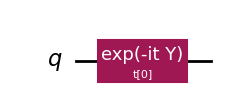

In [228]:
ansatz = UCCSD(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        tapered_mapper,
        initial_state=HartreeFock(
            electronic_structure.num_spatial_orbitals,
            electronic_structure.num_particles,
            tapered_mapper,
        ),
    )
num_params = ansatz.num_parameters

ansatz.decompose().draw("mpl")

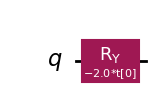

In [229]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

ansatz_isa.draw(output="mpl")

In [230]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0] + nuclear_repulsion_energy

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

nuclear_repulsion_energy = electronic_structure.nuclear_repulsion_energy

In [231]:
# x0 = 2 * np.pi * np.random.random(num_params)
x0 = np.zeros(num_params)
x0

array([0.])

In [232]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -1.1135595252213162]
Iters. done: 2 [Current cost: 0.171780744989813]
Iters. done: 3 [Current cost: -0.15669116567068253]
Iters. done: 4 [Current cost: -0.8777686921603663]
Iters. done: 5 [Current cost: -0.92763855641545]
Iters. done: 6 [Current cost: -1.1380661742082299]
Iters. done: 7 [Current cost: -1.094745720980561]
Iters. done: 8 [Current cost: -1.1294270712715901]
Iters. done: 9 [Current cost: -1.1388432417588485]
Iters. done: 10 [Current cost: -1.1343376062627968]
Iters. done: 11 [Current cost: -1.1396912791509783]
Iters. done: 12 [Current cost: -1.1388960455275106]
Iters. done: 13 [Current cost: -1.1369172563115013]
Iters. done: 14 [Current cost: -1.137023393364415]
Iters. done: 15 [Current cost: -1.135397811857636]
Iters. done: 16 [Current cost: -1.1375357007498978]
Iters. done: 17 [Current cost: -1.131104450467412]
Iters. done: 18 [Current cost: -1.1327122895138126]
Iters. done: 19 [Current cost: -1.1354332438268329]
Iters. done: 20 [Current cos

In [233]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.133418969690068
       x: [-7.823e-02]
    nfev: 20
   maxcv: 0.0

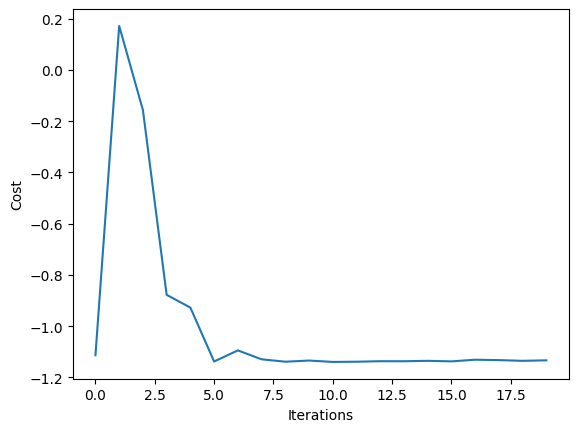

In [234]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()